## Identifying disease related cell subtypes

In [1]:
import ggml_ot
import scanpy as sc

In this tutorial, we explore the biological interpretation of the model learned with `ggml_ot`. We demonstrate functions to compute and visualize:
- low-dimensional cell embedding in the learned subspace
- gene ranking for each component
- gene enrichment analysis for each component



Load the data (Myocardial Infarction dataset from Kuppe et. al, 2022) and train the model as before.

/home/kuehn/ot_metric_learning/gaussian-ground-metric-learning/code/ggml-ot_privat/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:744: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


Patient CK376 has only 25 cells which is less than specified n_cells=50, skipping
Patient CK365 has only 41 cells which is less than specified n_cells=50, skipping
Patient CK369 has only 17 cells which is less than specified n_cells=50, skipping
Compute all OT distances after 10 iterations


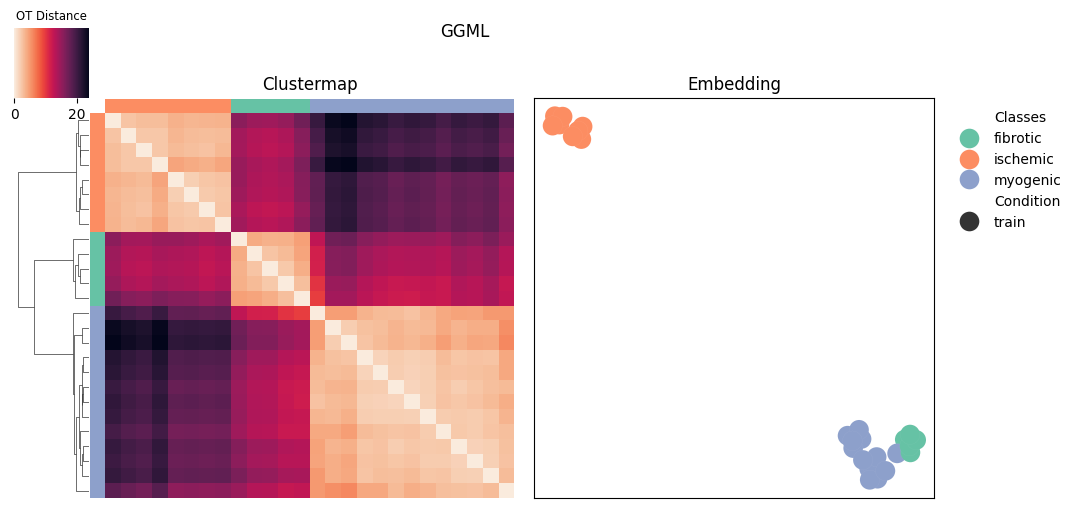

In [2]:
id = "c1f6034b-7973-45e1-85e7-16933d0550bc.h5ad"
adata = ggml_ot.data.load_cellxgene(id)
adata = adata[adata.obs["cell_type"]=="cardiac muscle myoblast"] 

sc.pp.highly_variable_genes(adata,n_top_genes=2000,subset=True)

dataset = ggml_ot.from_anndata(adata,n_cells=50)

dataset.train(alpha=10, reg=1, n_comps=2, reg_type=2, max_iterations=5, verbose=False)

Here, we see the patient-level OT distances with the learned ground metric capture the patient's disease states.

## Learned Gene Subspace

Let's now have a look at the cell-level distances of the learned ground metric, i.e. the cells in the learned low-dimensional gene subspace that captures the patient's disease state under OT.

Here, we plot "COL8A1" and "EMC10" as example marker genes. We obtain these marker genes by ranking the genes for the X_ggml loadings in the next section.

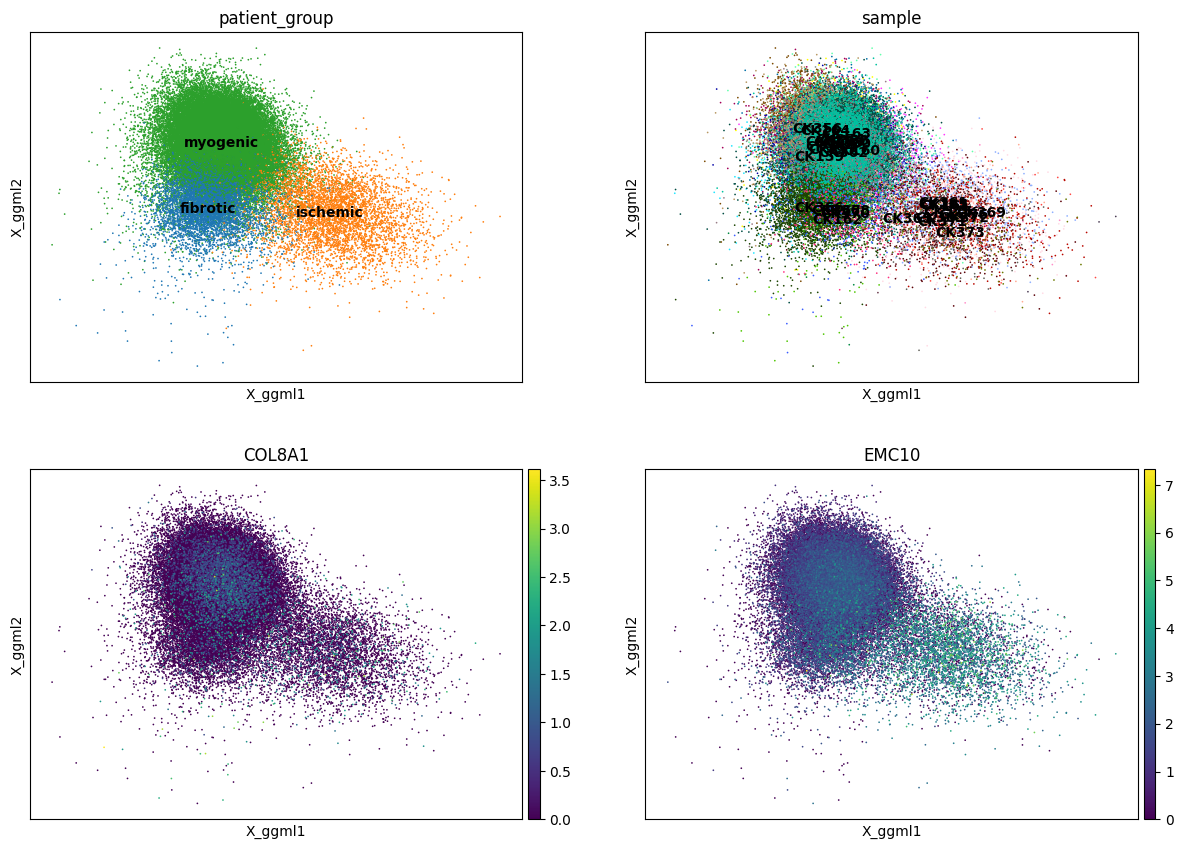

In [3]:
adata = dataset.adata

# Show cells embedded in low-dimensional gene subspace (adata.obsm["X_ggml"])
sc.pl.embedding(adata,basis="X_ggml",color=["patient_group","sample","COL8A1","EMC10"], 
                s=6,gene_symbols="feature_name",use_raw=False,ncols=2,legend_loc='on data') 

Compare this to a traditional UMAP of the full gene space.

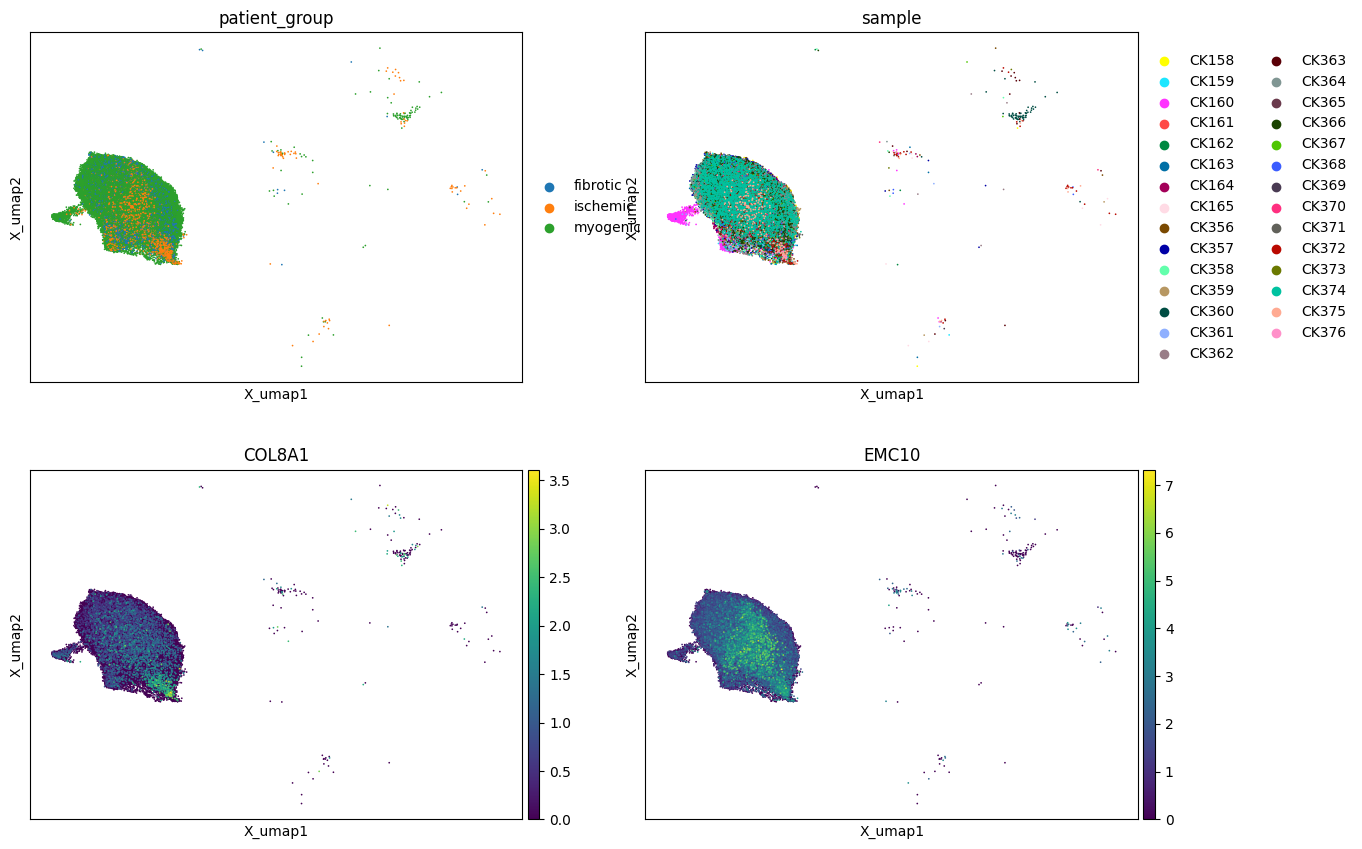

In [4]:
# Show cells embedded in low-dimensional gene subspace (adata.obsm["X_ggml"])
sc.pl.embedding(adata,basis="X_umap",color=["patient_group","sample","COL8A1","EMC10"], 
                s=6,gene_symbols="feature_name",use_raw=False,ncols=2) 

## Gene importance in GGML loadings

The function ``gene.ranking`` ranks the genes for each component of the learned gene subspace. It behaves like `scanpy.pl.pca_loadings`, but on `.varm["W_ggml"]` instead of `.varm["PCs]`.

In our example, we want to find out the ten most important genes in each component.

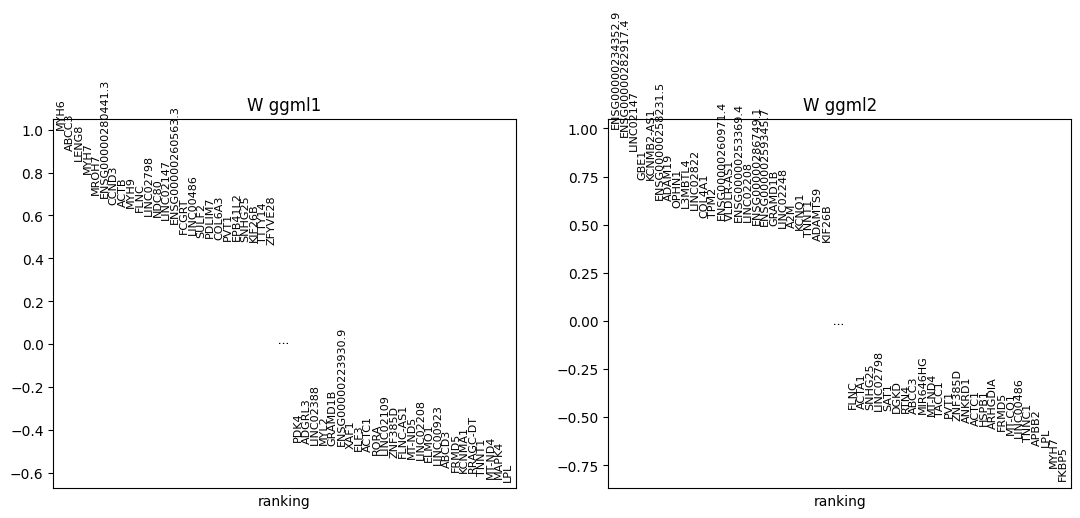

In [5]:
ggml_ot.gene.ranking(adata,gene_symbols="feature_name",n_genes=50)

We can also investigate these identified genes specifically the cell_types that express them. 

X_ggml of fibroblast of cardiac tissue


/home/kuehn/ot_metric_learning/gaussian-ground-metric-learning/code/ggml-ot_privat/.venv/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1150: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(
/home/kuehn/ot_metric_learning/gaussian-ground-metric-learning/code/ggml-ot_privat/.venv/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list
/home/kuehn/ot_metric_learning/gaussian-ground-metric-learning/code/ggml-ot_privat/.venv/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1150: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


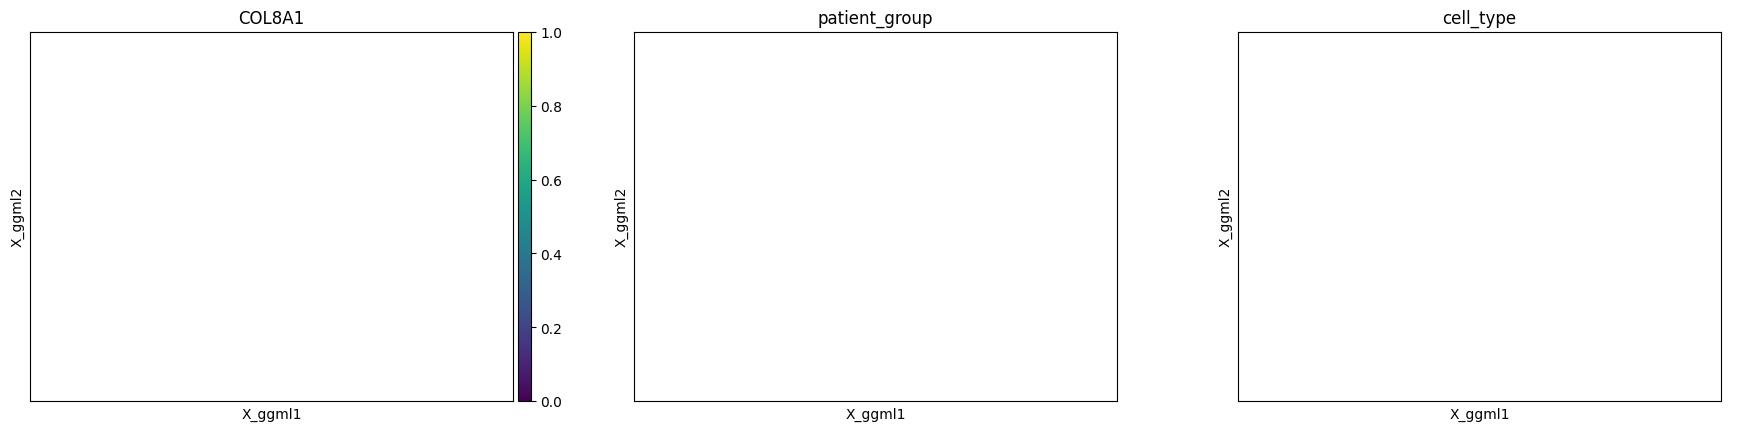

X_umap of fibroblast of cardiac tissue


/home/kuehn/ot_metric_learning/gaussian-ground-metric-learning/code/ggml-ot_privat/.venv/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1150: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(
/home/kuehn/ot_metric_learning/gaussian-ground-metric-learning/code/ggml-ot_privat/.venv/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1150: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


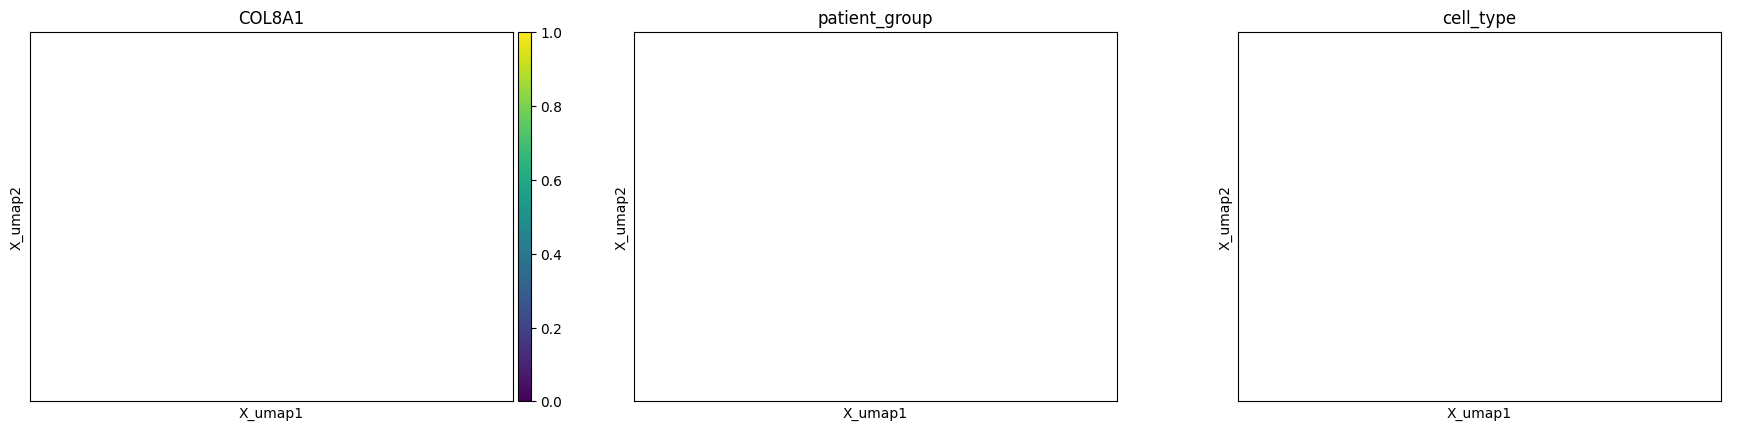

X_ggml of cardiac muscle myoblast


/home/kuehn/ot_metric_learning/gaussian-ground-metric-learning/code/ggml-ot_privat/.venv/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


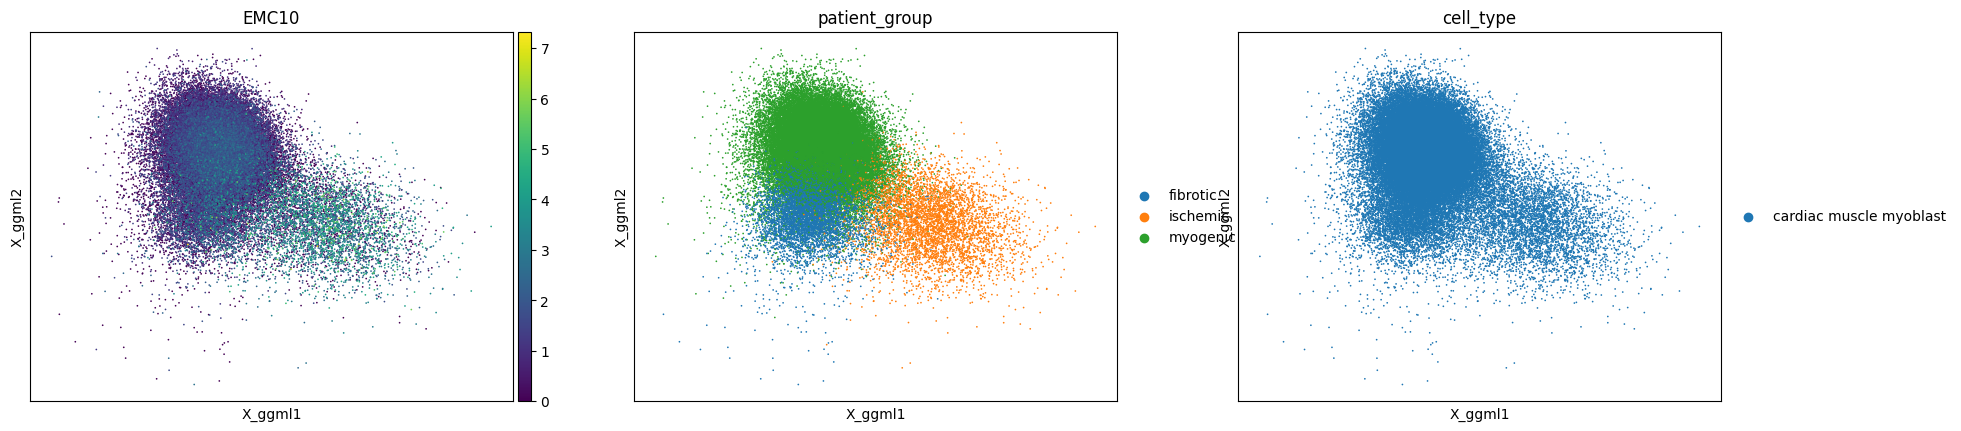

X_umap of cardiac muscle myoblast


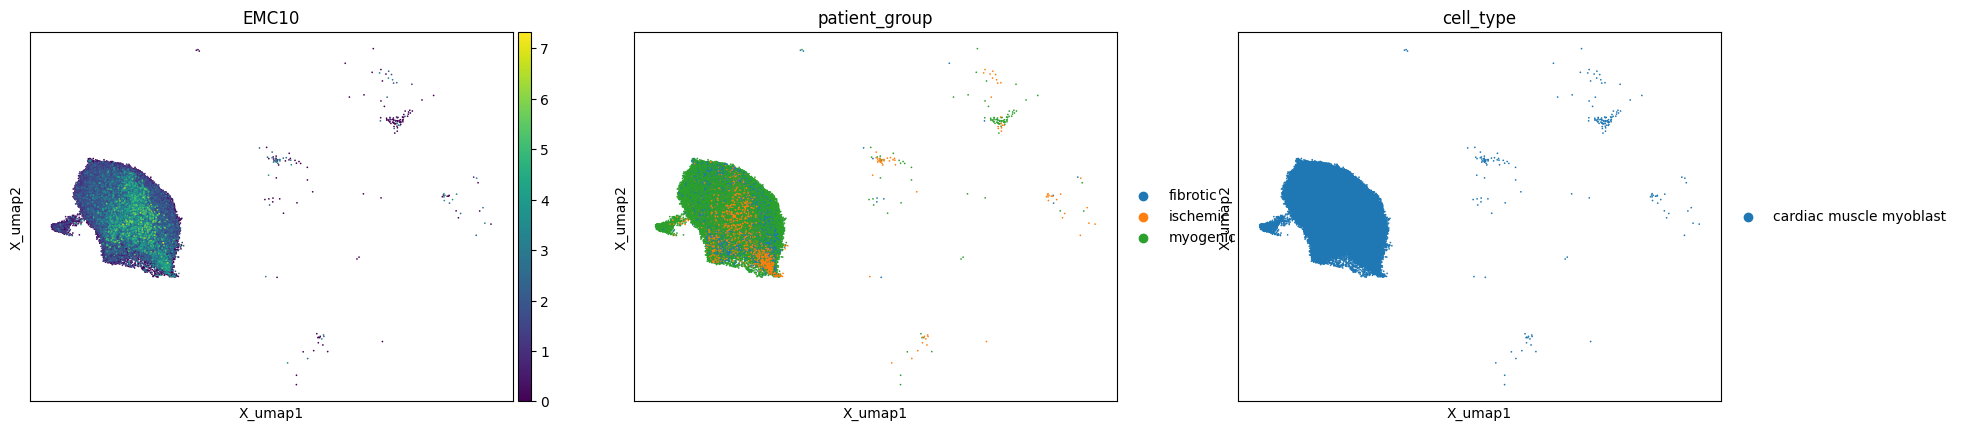

In [6]:
plot_cols = ["patient_group","cell_type"]
selected_genes = {
    "fibroblast of cardiac tissue": ["COL8A1"],
    "cardiac muscle myoblast": ["EMC10"],
}

for celltype in selected_genes.keys():
    sub_adata = adata[adata.obs["cell_type"]==celltype] 
    for emb in ["X_ggml","X_umap"]:
        print(f"{emb} of {celltype}")
        sc.pl.embedding(sub_adata,basis=emb,color=selected_genes[celltype]+plot_cols,
                        gene_symbols="feature_name", use_raw=False, s=6) 


## Gene enrichment of GGML loadings

With ``gene.enrichment()``, we take the most important genes from each loading and check if they are linked to known biological processes. 

In the following, we consider top 50 genes for each loading and perform gene enrichment analysis. By default, we consider the ordering of the gene ranking (`ordered=True`)

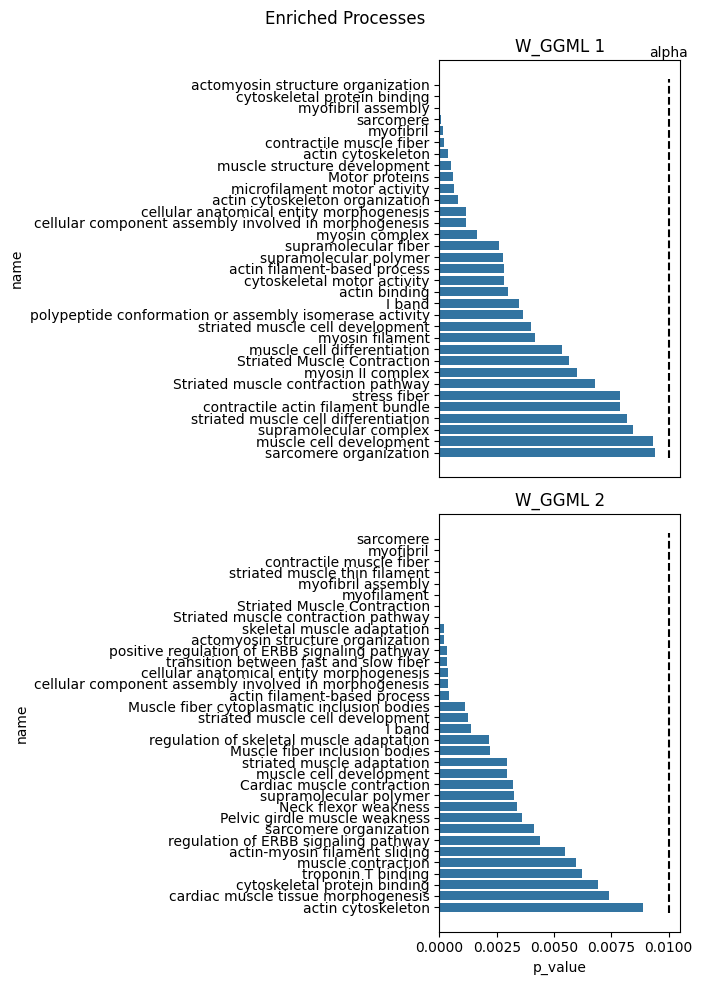

In [7]:
ggml_ot.gene.enrichment(adata,gene_symbols="feature_name",n_genes=50,alpha=0.01)